### ref
- [ゼロから作るDeep Learning](https://www.amazon.co.jp/%E3%82%BC%E3%83%AD%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8BDeep-Learning-Python%E3%81%A7%E5%AD%A6%E3%81%B6%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0%E3%81%AE%E7%90%86%E8%AB%96%E3%81%A8%E5%AE%9F%E8%A3%85-%E6%96%8E%E8%97%A4-%E5%BA%B7%E6%AF%85/dp/4873117585/ref=sr_1_1?ie=UTF8&qid=1494484778&sr=8-1&keywords=0%E3%81%8B%E3%82%89%E4%BD%9C%E3%82%8B%E3%83%87%E3%82%A3%E3%83%BC%E3%83%97%E3%83%A9%E3%83%BC%E3%83%8B%E3%83%B3%E3%82%B0)
- [pytorch.org](http://pytorch.org/)

# パーセプトロン・活性化関数・誤差関数・誤差逆伝播
## パーセプトロン
パーセプトロンはニューラルネットワークの元となったモデルで、入力と出力のみからなるモデルです。
このパーセプトロンはXORすら解けない程度でした。パーセプトロンの関数としての問題は、**線形**であったことです。
> ここでいう線形関数は、$f(x + y) = f(x) + f(y)$を満たすような関数です。

![linear](./images/linear.png)
![non-linear](./images/non_linear.png)

線形だと下のセルにある図1のような問題を解けません。図1にあるような問題を線形分離不可能と言います。
このような問題は複数の直線か曲線でないと分離できません。一方、
線形分離可能な問題というのはクラスタを直線で分離できるようなものです（fig 2.）。
![fig 1](./images/fig_01.png)
![fig 2](./images/fig_02.png)

## 活性化関数
ニューラルネットワークは非線形な関数ですが、シンプルには線形な関数を非線形にするために活性化関数を用います。
活性化関数を適用する位置はスライド参照。  
活性化関数はニューロンの発火にインスパイアされたもので、初めはステップ関数が使われていましたが、誤差を用いたパラメータ更新（学習）のことを
考えて、微分可能な`sigmoid`関数が用いられるようになりました。現在では`ReLU`やその派生が主流になっています。
`ReLU`が主流になっている理由としては、計算が速いことと微分が楽なことが挙げられます。  
ほとんどの問題で、「線形変換によってデータの次元数を減らし、活性化関数を適用する」と言う処理を繰り返して出力します。
![fig 3](./images/fig_03.png)
![fig 4](./images/fig_04.png)
![fig 5](./images/fig_05.png)
![fig 6](./images/fig_06.png)

## 誤差関数
誤差関数は各タスクに合わせて設計されます。回帰問題では二乗誤差、識別問題では交差エントロピー（sigmoid cross entropy、softmax cross entropy）
が主流です。  
モデルの出力を$\hat{\boldsymbol{y}}$、正解を$\boldsymbol{y}$とすると、
二乗誤差は、$|| \boldsymbol{y} - \hat{\boldsymbol{y}}||^2$、交差エントロピーは$ - \boldsymbol{y}\cdot \log \hat{\boldsymbol{y}}$
で計算できます。
表記に関しては誤差の値自体は$\bf{E}$、誤差関数は$L(\hat{\boldsymbol{y}}, \boldsymbol{y}), \ L$と表すことが多いです。

![fig 7](./images/fig_07.png)

普通、誤差は小さいほど良いです。　ただし、前回（4/16）に伝えた通り誤差は2種類あります。前回は図をお見せすることが
できませんでしたが、下の図[^1]（青が訓練誤差、オレンジが汎化誤差を表す）では実際に初めは2つの誤差が
順調に下がっていますが10epochあたりを境に汎化誤差は上がり始めています。そのため、このモデルは100epoch学習したもの
よりも10epochあたりのものの方が未知のデータに対して精度が高いと想像できます。

![overfitting](https://github.com/mitmul/chainer-handson/blob/master/DeepCNN_cifar10_result/loss.png?raw=true)

[^1]: image from https://github.com/mitmul/chainer-handson

### 誤差の計算について
**訓練誤差、汎化誤差をどういうときに計算し、どのように言葉を使い分けるかについて。**
訓練誤差と汎化誤差の計算方法は全く同じですがデータが*学習データかテストデータか*の違いがあります。
また、誤差がパラメータの更新に使われるかどうかという大きな違いもあります。
訓練誤差はパラメータ更新に使われますが、汎化誤差は学習の状況（過学習しているかなど）を見るためだけに計算します。
そのため、多くのライブラリでモデルが学習用の計算かどうかをフラグで管理したり、変数が勾配を保持しないようにするためのフラグがあります。
今回使うpytorchでは、モデルに対しては学習時には`model.train()`、評価（汎化誤差を計算する時や実際に運用する時）の時には`model.eval()`という
メソッドが、変数クラス`Variable`には変数定義時に`Variable(data, volatile=True)`などと宣言します。

## 誤差逆伝播
偏微分・連鎖律がベースになっています。実際に扱う場合はフレームワークがよしなにやってくれているので特に説明しません。
この誤差逆伝播で各レイヤーに誤差を渡し、その誤差を用いてパラメータを更新します。

ここでは、PyTorchを用いて（toy dataで）誤差逆伝播をほぼ意識することなく実行できることを
以下のコードを直下のセルにコピペして確認しましょう。`ctrl + b -> cmd + p -> shift + return`

---

```back_prop_check.py
import torch
from torch.autograd import Variable

x = Variable(torch.ones(2, 2), requires_grad=True)
z = (x + 2) * (x + 2) * 3
print('z: {}'.format(z))
out = z.mean()
print('out: {}'.format(out))
out.backward()
print(x.grad)
```

---

上のsnippetでは
${\rm out} = \dfrac{1}{4}\sum_{i=1}^4 z_i =  \dfrac{1}{4}\sum_{i=1}^4 3 (x_i + 2)^2$より
$\dfrac{\partial {\rm out}}{\partial x_i} = \dfrac{\partial {\rm out}}{\partial z_i} \dfrac{\partial z_i}{\partial x_i} = \dfrac{3}{2}(x_i + 2) |_{x_i = 1} = 4.5$
が正解

誤差逆伝播の確認↓

# ニューラルネット
## 学習の流れ

### ミニバッチ
データセットの大きさを$N$とするとデータセットは教師あり学習の場合は$(\boldsymbol{x}_i, \boldsymbol{y}_i)_{i= 1}^N$と表せます。
バッチ処理はデータセットのすべてのデータに対して誤差を計算し、パラメータを更新する方法ですが、$N = 10,000$を超えることがほとんどの場合、
誤差を計算する回数に対してアップデートの回数が少なく、学習に時間がかかります。そのため、一般的には$n = 32$ぐらいのデータ（ミニバッチ）ごとに
アップデートを行い、プログラム中ではミニバッチを1つの変数のように扱います。
データの次元数が$d_{data}$の時、ミニバッチの形は$n \times d_{data}$になります。

よく、「学習は100epochで1epochは300iteration」などの言い方をしますが、
データセットの大きさを$N$、ミニバッチの大きさを$n$とすると、イテレーション数は$N / n$となり、これが1epochに該当します。

<!--
## 実装
コードを書いていきましょう。
-->

## データの扱い方
ミニバッチを1つの変数として扱うので学習ループ内での各変数の形は`[batch_size, *data_shape]`になります。

## モデルの構造
モデルはレイヤー（線形変換）と活性化関数（非線形）で作られていますが、どちらも関数であることに変わりはないです。しかし、
レイヤーは重みが更新されるので学習するにつれてその出力は変化します。`モデルの構造 1`では箱と箱を結ぶ線が活性化関数を、箱自体がレイヤーを表しています。また、`モデルの構造 2`では活性化関数が省略されています。  
多くのライブラリではレイヤーと活性化関数のファイルのディレクトリが分けられています。

###  レイヤー
- Linear / Dense / Full Connected
- Convolutional
- Recurrent (LSTM)
- Normalisation
    - (Dropout)
    - Batch Normalization
    
### 活性化関数
- tanh
- sigmoid
- relu
    - leaky relu
    - prelu
    - elu
    
## 多層パーセプトロン（Multi Layer Perceptron）
### どんなモデルか
多層パーセプトロンは`Linear`レイヤーのみからなるニューラルネットワークです。
![mlp](./images/mat.png)
各ユニットについての計算は上の図内にある通りですし、行列の大きさを（縦 $\times$　横）で表すと、下の図のように行列の大きさを変更することができます。
![matrix](./images/matrix.png)

この性質を利用して、`Linear`レイヤーの計算ではミニバッチの計算を一度に行うことができます（下図）。
`Linear`レイヤーを扱う場合、入力データの形は（ミニバッチサイズ、（データの形））となります。
ここで説明した計算は、一度に複数の同じ形のニューラルネットワークの計算を行っているようなイメージです。

![linear](./images/linear_layer.png)

---

ここでは、まず有名な手書き数字データセットのMNISTを用いて多層パーセプトロンの実験を行います。
多層パーセプトロン（スライド参照）を実装しましょう。データセットはPyTorchに関数が用意されているのでそこから落とします。

MNISTのデータは$0$から$9$の10クラス分類で各データは$28 \times 28$の画像を下の図のように平らにした$784$次元です。
![flatten_mnist](./images/flatten_image.png)
この$784$次元のデータをいくつかの`Linear`を用いて$10$次元にしましょう。
ここで使えるレイヤーは

- `Linear`: 第1引数：入力データの次元数、第2引数：出力データの次元数
- `BatchNorm1d`: 引数は次元数
- `Dropout`: 引数は変数

で、活性化関数は

- `sigmoid`
- `relu`
- `tanh`

などです。

`import`する必要があるのは、

```mnit_mlp.py
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
```

In [1]:
%matplotlib inline
import os  # path
import datetime
import numpy as np  # 行列演算
import matplotlib.pyplot as plt  # グラフ
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if _cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=50, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./', train=False, transform=transforms.ToTensor()),
    batch_size=50, shuffle=True, **kwargs)

Files already downloaded


In [3]:
# モデルの定義
class SimpleLinear(nn.Module):
    
    def __init__(self, in_dim=784, out_dim=10, hidden_dim=100):
        super(SimpleLinear, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x.view(-1, 784)))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)
    
    def predict(self, x):
        return nn.Softmax(self.forward(x))

In [4]:
class SimpleLinearDr(nn.Module):
    
    def __init__(self, in_dim=784, hidden_dim=256, out_dim=10):
        super(SimpleLinearDr, self).__init__()
        self.fc1 = nn.Linear(in_dim, hidden_dim)
        self.dr1 = nn.Dropout()
        self.fc2 = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x):
        x = F.relu(self.dr1(self.fc1(x.view(-1, 784))))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

In [5]:
def train(epoch, log_interval=100):
    model.train()  # モデルがロスを用いて更新するように設定
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()  # モデルのレイヤーが前のエポックでの勾配履歴を保持しているので消去
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss += loss.data[0]
        loss.backward()  # 誤差逆伝播
        optimizer.step()  # パラメータを更新
        if batch_idx % log_interval == 0:
            print('Training')
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss:{:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                   100. * batch_idx / len(train_loader), loss.data[0]))
    return train_loss / len(train_loader)

def test(epoch):
    model.eval()  #  更新しないように設定
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target).data[0]
        pred = output.data.max(1)[1]
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(test_loader)
    print('Test')
    print('Average loss: {:.4f},\tAccuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, len(test_loader.dataset),
                                                                   100. * correct / len(test_loader.dataset)))
    return test_loss, correct

In [6]:
def run(n_epoch, train, test):
    train_loss = []
    test_loss = []
    test_accuracy = []
    start = datetime.datetime.now()
    print('Training started at {}'.format(start.strftime('%Y-%m-%d, %H:%M')))
    for epoch in range(1, n_epoch + 1):
        if epoch == 1:
            loop_start = datetime.datetime.now()
        train_loss.append(train(epoch))
        t_loss, t_accuracy = test(epoch)
        test_loss.append(t_loss)
        test_accuracy.append(t_accuracy)
        if epoch == 1:
            loop_end = datetime.datetime.now()
            print('one epoch takes {} sec'.format((loop_end - loop_start).total_seconds()))
    end = datetime.datetime.now()
    print('Training finished at {}'.format(end.strftime('%Y-%m-%d, %H:%M')))
    print('Duration: {}'.format((end - start).total_seconds()))
    return train_loss, test_loss, test_accuracy

In [7]:
def plot_results(train_loss, test_loss, test_accuracy=None, save=False, save_dir='./images/result'):
    time_stamp = datetime.datetime.now().strftime('%Y/%m/%d, %H:%M')
    f_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M')
    plt.plot(list(range(1, len(train_loss) + 1)), train_loss, label='train loss')
    plt.plot(list(range(1, len(test_loss) + 1)), test_loss, label='test loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.grid()
    plt.title('loss result at {}'.format(time_stamp))
    plt.legend()
    if save:
        tmp_save_dir = os.path.join(save_dir, 'loss')
        f_name = os.path.join(tmp_save_dir, '{}.png'.format(f_time))
        if not os.path.exists(tmp_save_dir):
            os.makedirs(tmp_save_dir)
        print('path to save loss: {}'.format(f_name))
        plt.savefig(f_name)
    plt.show()
    
    if test_accuracy is not None:
        plt.plot(list(range(1, len(test_accuracy) + 1)), list(np.asarray(test_accuracy) / 100.0), label='test accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.grid()
        plt.title('accuracy result at {}'.format(time_stamp))
        plt.legend()
        if save:
            tmp_save_dir = os.path.join(save_dir, 'accuracy')
            f_name = os.path.join(tmp_save_dir, '{}.png'.format(f_time))
            if not os.path.exists(tmp_save_dir):
                os.makedirs(tmp_save_dir)
            print('path to save accuracy: {}'.format(f_name))
            plt.savefig(f_name)
        plt.show()

### ミニマリズムなパーセプトロン

Training started at 2017-05-11, 19:48
Training
epoch: 1 [0/60000 (0%)]	loss:2.305885
Training
epoch: 1 [5000/60000 (8%)]	loss:0.669264
Training
epoch: 1 [10000/60000 (17%)]	loss:0.299714
Training
epoch: 1 [15000/60000 (25%)]	loss:0.449866
Training
epoch: 1 [20000/60000 (33%)]	loss:0.770694
Training
epoch: 1 [25000/60000 (42%)]	loss:0.823341
Training
epoch: 1 [30000/60000 (50%)]	loss:0.720491
Training
epoch: 1 [35000/60000 (58%)]	loss:0.600039
Training
epoch: 1 [40000/60000 (67%)]	loss:0.500082
Training
epoch: 1 [45000/60000 (75%)]	loss:0.368190
Training
epoch: 1 [50000/60000 (83%)]	loss:0.386970
Training
epoch: 1 [55000/60000 (92%)]	loss:0.380968
Test
Average loss: 0.4138,	Accuracy: 8521/10000 (85%)
one epoch takes 5.872084 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.290731
Training
epoch: 2 [5000/60000 (8%)]	loss:0.496798
Training
epoch: 2 [10000/60000 (17%)]	loss:0.289335
Training
epoch: 2 [15000/60000 (25%)]	loss:0.278812
Training
epoch: 2 [20000/60000 (33%)]	loss:0.300606
Training


Training
epoch: 13 [5000/60000 (8%)]	loss:0.459943
Training
epoch: 13 [10000/60000 (17%)]	loss:0.476923
Training
epoch: 13 [15000/60000 (25%)]	loss:0.370381
Training
epoch: 13 [20000/60000 (33%)]	loss:0.375124
Training
epoch: 13 [25000/60000 (42%)]	loss:0.185217
Training
epoch: 13 [30000/60000 (50%)]	loss:0.366306
Training
epoch: 13 [35000/60000 (58%)]	loss:0.144948
Training
epoch: 13 [40000/60000 (67%)]	loss:0.070204
Training
epoch: 13 [45000/60000 (75%)]	loss:0.185191
Training
epoch: 13 [50000/60000 (83%)]	loss:0.239418
Training
epoch: 13 [55000/60000 (92%)]	loss:0.375208
Test
Average loss: 0.3173,	Accuracy: 8771/10000 (88%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.144716
Training
epoch: 14 [5000/60000 (8%)]	loss:0.249405
Training
epoch: 14 [10000/60000 (17%)]	loss:0.231285
Training
epoch: 14 [15000/60000 (25%)]	loss:0.203327
Training
epoch: 14 [20000/60000 (33%)]	loss:0.279871
Training
epoch: 14 [25000/60000 (42%)]	loss:0.325992
Training
epoch: 14 [30000/60000 (50%)]	loss:0.050330
T

Training
epoch: 25 [5000/60000 (8%)]	loss:0.230308
Training
epoch: 25 [10000/60000 (17%)]	loss:0.185547
Training
epoch: 25 [15000/60000 (25%)]	loss:0.369816
Training
epoch: 25 [20000/60000 (33%)]	loss:0.184799
Training
epoch: 25 [25000/60000 (42%)]	loss:0.138388
Training
epoch: 25 [30000/60000 (50%)]	loss:0.277408
Training
epoch: 25 [35000/60000 (58%)]	loss:0.148956
Training
epoch: 25 [40000/60000 (67%)]	loss:0.276795
Training
epoch: 25 [45000/60000 (75%)]	loss:0.139032
Training
epoch: 25 [50000/60000 (83%)]	loss:0.235301
Training
epoch: 25 [55000/60000 (92%)]	loss:0.374339
Test
Average loss: 0.3448,	Accuracy: 8749/10000 (87%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.189657
Training
epoch: 26 [5000/60000 (8%)]	loss:0.230327
Training
epoch: 26 [10000/60000 (17%)]	loss:0.184513
Training
epoch: 26 [15000/60000 (25%)]	loss:0.231776
Training
epoch: 26 [20000/60000 (33%)]	loss:0.230601
Training
epoch: 26 [25000/60000 (42%)]	loss:0.184586
Training
epoch: 26 [30000/60000 (50%)]	loss:0.322742
T

Training
epoch: 37 [5000/60000 (8%)]	loss:0.230506
Training
epoch: 37 [10000/60000 (17%)]	loss:0.184269
Training
epoch: 37 [15000/60000 (25%)]	loss:0.276894
Training
epoch: 37 [20000/60000 (33%)]	loss:0.184691
Training
epoch: 37 [25000/60000 (42%)]	loss:0.138487
Training
epoch: 37 [30000/60000 (50%)]	loss:0.368662
Training
epoch: 37 [35000/60000 (58%)]	loss:0.184665
Training
epoch: 37 [40000/60000 (67%)]	loss:0.184384
Training
epoch: 37 [45000/60000 (75%)]	loss:0.145426
Training
epoch: 37 [50000/60000 (83%)]	loss:0.230648
Training
epoch: 37 [55000/60000 (92%)]	loss:0.047080
Test
Average loss: 0.3561,	Accuracy: 8767/10000 (88%)
Training
epoch: 38 [0/60000 (0%)]	loss:0.368663
Training
epoch: 38 [5000/60000 (8%)]	loss:0.414742
Training
epoch: 38 [10000/60000 (17%)]	loss:0.230462
Training
epoch: 38 [15000/60000 (25%)]	loss:0.230566
Training
epoch: 38 [20000/60000 (33%)]	loss:0.000118
Training
epoch: 38 [25000/60000 (42%)]	loss:0.322379
Training
epoch: 38 [30000/60000 (50%)]	loss:0.092207
T

Training
epoch: 49 [5000/60000 (8%)]	loss:0.138234
Training
epoch: 49 [10000/60000 (17%)]	loss:0.323266
Training
epoch: 49 [15000/60000 (25%)]	loss:0.276403
Training
epoch: 49 [20000/60000 (33%)]	loss:0.092176
Training
epoch: 49 [25000/60000 (42%)]	loss:0.230282
Training
epoch: 49 [30000/60000 (50%)]	loss:0.322539
Training
epoch: 49 [35000/60000 (58%)]	loss:0.138195
Training
epoch: 49 [40000/60000 (67%)]	loss:0.506573
Training
epoch: 49 [45000/60000 (75%)]	loss:0.086946
Training
epoch: 49 [50000/60000 (83%)]	loss:0.191358
Training
epoch: 49 [55000/60000 (92%)]	loss:0.199896
Test
Average loss: 0.3842,	Accuracy: 8728/10000 (87%)
Training
epoch: 50 [0/60000 (0%)]	loss:0.276504
Training
epoch: 50 [5000/60000 (8%)]	loss:0.323294
Training
epoch: 50 [10000/60000 (17%)]	loss:0.276882
Training
epoch: 50 [15000/60000 (25%)]	loss:0.092229
Training
epoch: 50 [20000/60000 (33%)]	loss:0.138165
Training
epoch: 50 [25000/60000 (42%)]	loss:0.230994
Training
epoch: 50 [30000/60000 (50%)]	loss:0.184312
T

Training
epoch: 61 [5000/60000 (8%)]	loss:0.138157
Training
epoch: 61 [10000/60000 (17%)]	loss:0.184250
Training
epoch: 61 [15000/60000 (25%)]	loss:0.092224
Training
epoch: 61 [20000/60000 (33%)]	loss:0.232292
Training
epoch: 61 [25000/60000 (42%)]	loss:0.368418
Training
epoch: 61 [30000/60000 (50%)]	loss:0.230287
Training
epoch: 61 [35000/60000 (58%)]	loss:0.138236
Training
epoch: 61 [40000/60000 (67%)]	loss:0.184890
Training
epoch: 61 [45000/60000 (75%)]	loss:0.140107
Training
epoch: 61 [50000/60000 (83%)]	loss:0.276311
Training
epoch: 61 [55000/60000 (92%)]	loss:0.138167
Test
Average loss: 0.3812,	Accuracy: 8752/10000 (88%)
Training
epoch: 62 [0/60000 (0%)]	loss:0.369125
Training
epoch: 62 [5000/60000 (8%)]	loss:0.414689
Training
epoch: 62 [10000/60000 (17%)]	loss:0.138885
Training
epoch: 62 [15000/60000 (25%)]	loss:0.322489
Training
epoch: 62 [20000/60000 (33%)]	loss:0.230265
Training
epoch: 62 [25000/60000 (42%)]	loss:0.508123
Training
epoch: 62 [30000/60000 (50%)]	loss:0.145917
T

Training
epoch: 73 [5000/60000 (8%)]	loss:0.506586
Training
epoch: 73 [10000/60000 (17%)]	loss:0.230309
Training
epoch: 73 [15000/60000 (25%)]	loss:0.093960
Training
epoch: 73 [20000/60000 (33%)]	loss:0.276997
Training
epoch: 73 [25000/60000 (42%)]	loss:0.276326
Training
epoch: 73 [30000/60000 (50%)]	loss:0.092108
Training
epoch: 73 [35000/60000 (58%)]	loss:0.184237
Training
epoch: 73 [40000/60000 (67%)]	loss:0.270031
Training
epoch: 73 [45000/60000 (75%)]	loss:0.092104
Training
epoch: 73 [50000/60000 (83%)]	loss:0.368424
Training
epoch: 73 [55000/60000 (92%)]	loss:0.235666
Test
Average loss: 0.3989,	Accuracy: 8758/10000 (88%)
Training
epoch: 74 [0/60000 (0%)]	loss:0.322363
Training
epoch: 74 [5000/60000 (8%)]	loss:0.138161
Training
epoch: 74 [10000/60000 (17%)]	loss:0.093030
Training
epoch: 74 [15000/60000 (25%)]	loss:0.416155
Training
epoch: 74 [20000/60000 (33%)]	loss:0.187977
Training
epoch: 74 [25000/60000 (42%)]	loss:0.322553
Training
epoch: 74 [30000/60000 (50%)]	loss:0.184247
T

Training
epoch: 85 [5000/60000 (8%)]	loss:0.276409
Training
epoch: 85 [10000/60000 (17%)]	loss:0.230266
Training
epoch: 85 [15000/60000 (25%)]	loss:0.184378
Training
epoch: 85 [20000/60000 (33%)]	loss:0.184207
Training
epoch: 85 [25000/60000 (42%)]	loss:0.276323
Training
epoch: 85 [30000/60000 (50%)]	loss:0.322387
Training
epoch: 85 [35000/60000 (58%)]	loss:0.414469
Training
epoch: 85 [40000/60000 (67%)]	loss:0.230900
Training
epoch: 85 [45000/60000 (75%)]	loss:0.508364
Training
epoch: 85 [50000/60000 (83%)]	loss:0.138474
Training
epoch: 85 [55000/60000 (92%)]	loss:0.415038
Test
Average loss: 0.3997,	Accuracy: 8784/10000 (88%)
Training
epoch: 86 [0/60000 (0%)]	loss:0.000007
Training
epoch: 86 [5000/60000 (8%)]	loss:0.322364
Training
epoch: 86 [10000/60000 (17%)]	loss:0.368448
Training
epoch: 86 [15000/60000 (25%)]	loss:0.322376
Training
epoch: 86 [20000/60000 (33%)]	loss:0.092104
Training
epoch: 86 [25000/60000 (42%)]	loss:0.092119
Training
epoch: 86 [30000/60000 (50%)]	loss:0.368435
T

Training
epoch: 97 [5000/60000 (8%)]	loss:0.322364
Training
epoch: 97 [10000/60000 (17%)]	loss:0.276313
Training
epoch: 97 [15000/60000 (25%)]	loss:0.230306
Training
epoch: 97 [20000/60000 (33%)]	loss:0.276331
Training
epoch: 97 [25000/60000 (42%)]	loss:0.184207
Training
epoch: 97 [30000/60000 (50%)]	loss:0.230271
Training
epoch: 97 [35000/60000 (58%)]	loss:0.368426
Training
epoch: 97 [40000/60000 (67%)]	loss:0.046053
Training
epoch: 97 [45000/60000 (75%)]	loss:0.506596
Training
epoch: 97 [50000/60000 (83%)]	loss:0.138188
Training
epoch: 97 [55000/60000 (92%)]	loss:0.184383
Test
Average loss: 0.4059,	Accuracy: 8754/10000 (88%)
Training
epoch: 98 [0/60000 (0%)]	loss:0.184213
Training
epoch: 98 [5000/60000 (8%)]	loss:0.327991
Training
epoch: 98 [10000/60000 (17%)]	loss:0.230286
Training
epoch: 98 [15000/60000 (25%)]	loss:0.276310
Training
epoch: 98 [20000/60000 (33%)]	loss:0.276330
Training
epoch: 98 [25000/60000 (42%)]	loss:0.230260
Training
epoch: 98 [30000/60000 (50%)]	loss:0.368426
T

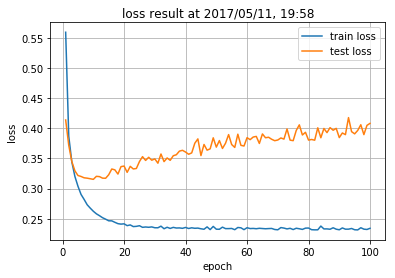

path to save accuracy: ./images/result/accuracy/2017_05_11_19_58.png


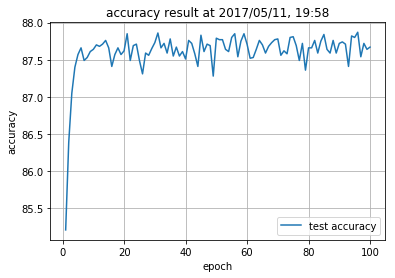

In [11]:
model = SimpleLinear()
optimizer = optim.Adam(model.parameters())
train_loss, test_loss, test_accuracy = run(100, train, test)
plot_results(train_loss, test_loss, test_accuracy, save=True)

### optimizerの違い

Training started at 2017-05-11, 20:05
Training
epoch: 1 [0/60000 (0%)]	loss:2.311881
Training
epoch: 1 [5000/60000 (8%)]	loss:0.836206
Training
epoch: 1 [10000/60000 (17%)]	loss:0.240192
Training
epoch: 1 [15000/60000 (25%)]	loss:0.206488
Training
epoch: 1 [20000/60000 (33%)]	loss:0.103972
Training
epoch: 1 [25000/60000 (42%)]	loss:0.278912
Training
epoch: 1 [30000/60000 (50%)]	loss:0.489706
Training
epoch: 1 [35000/60000 (58%)]	loss:0.251898
Training
epoch: 1 [40000/60000 (67%)]	loss:0.128048
Training
epoch: 1 [45000/60000 (75%)]	loss:0.140235
Training
epoch: 1 [50000/60000 (83%)]	loss:0.187136
Training
epoch: 1 [55000/60000 (92%)]	loss:0.008037
Test
Average loss: 0.1368,	Accuracy: 9571/10000 (96%)
one epoch takes 5.228992 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.171980
Training
epoch: 2 [5000/60000 (8%)]	loss:0.097608
Training
epoch: 2 [10000/60000 (17%)]	loss:0.079565
Training
epoch: 2 [15000/60000 (25%)]	loss:0.141503
Training
epoch: 2 [20000/60000 (33%)]	loss:0.075233
Training


Training
epoch: 13 [5000/60000 (8%)]	loss:0.002890
Training
epoch: 13 [10000/60000 (17%)]	loss:0.013510
Training
epoch: 13 [15000/60000 (25%)]	loss:0.000184
Training
epoch: 13 [20000/60000 (33%)]	loss:0.001734
Training
epoch: 13 [25000/60000 (42%)]	loss:0.044614
Training
epoch: 13 [30000/60000 (50%)]	loss:0.000139
Training
epoch: 13 [35000/60000 (58%)]	loss:0.000280
Training
epoch: 13 [40000/60000 (67%)]	loss:0.166062
Training
epoch: 13 [45000/60000 (75%)]	loss:0.017981
Training
epoch: 13 [50000/60000 (83%)]	loss:0.000758
Training
epoch: 13 [55000/60000 (92%)]	loss:0.000156
Test
Average loss: 0.1407,	Accuracy: 9708/10000 (97%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.000153
Training
epoch: 14 [5000/60000 (8%)]	loss:0.006224
Training
epoch: 14 [10000/60000 (17%)]	loss:0.006030
Training
epoch: 14 [15000/60000 (25%)]	loss:0.001252
Training
epoch: 14 [20000/60000 (33%)]	loss:0.287594
Training
epoch: 14 [25000/60000 (42%)]	loss:0.000306
Training
epoch: 14 [30000/60000 (50%)]	loss:0.006242
T

Training
epoch: 25 [5000/60000 (8%)]	loss:0.000091
Training
epoch: 25 [10000/60000 (17%)]	loss:0.016119
Training
epoch: 25 [15000/60000 (25%)]	loss:0.019022
Training
epoch: 25 [20000/60000 (33%)]	loss:0.000835
Training
epoch: 25 [25000/60000 (42%)]	loss:0.065041
Training
epoch: 25 [30000/60000 (50%)]	loss:0.001392
Training
epoch: 25 [35000/60000 (58%)]	loss:0.001201
Training
epoch: 25 [40000/60000 (67%)]	loss:0.002625
Training
epoch: 25 [45000/60000 (75%)]	loss:0.000054
Training
epoch: 25 [50000/60000 (83%)]	loss:0.001359
Training
epoch: 25 [55000/60000 (92%)]	loss:0.000224
Test
Average loss: 0.1854,	Accuracy: 9722/10000 (97%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.000016
Training
epoch: 26 [5000/60000 (8%)]	loss:0.003919
Training
epoch: 26 [10000/60000 (17%)]	loss:0.000114
Training
epoch: 26 [15000/60000 (25%)]	loss:0.005487
Training
epoch: 26 [20000/60000 (33%)]	loss:0.000160
Training
epoch: 26 [25000/60000 (42%)]	loss:0.037677
Training
epoch: 26 [30000/60000 (50%)]	loss:0.000016
T

Training
epoch: 37 [5000/60000 (8%)]	loss:0.001159
Training
epoch: 37 [10000/60000 (17%)]	loss:0.000115
Training
epoch: 37 [15000/60000 (25%)]	loss:0.000188
Training
epoch: 37 [20000/60000 (33%)]	loss:0.004900
Training
epoch: 37 [25000/60000 (42%)]	loss:0.001515
Training
epoch: 37 [30000/60000 (50%)]	loss:0.000425
Training
epoch: 37 [35000/60000 (58%)]	loss:0.000037
Training
epoch: 37 [40000/60000 (67%)]	loss:0.000008
Training
epoch: 37 [45000/60000 (75%)]	loss:0.000866
Training
epoch: 37 [50000/60000 (83%)]	loss:0.170830
Training
epoch: 37 [55000/60000 (92%)]	loss:0.000170
Test
Average loss: 0.2160,	Accuracy: 9767/10000 (98%)
Training
epoch: 38 [0/60000 (0%)]	loss:0.102221
Training
epoch: 38 [5000/60000 (8%)]	loss:0.000001
Training
epoch: 38 [10000/60000 (17%)]	loss:0.007384
Training
epoch: 38 [15000/60000 (25%)]	loss:0.000001
Training
epoch: 38 [20000/60000 (33%)]	loss:0.001584
Training
epoch: 38 [25000/60000 (42%)]	loss:0.051005
Training
epoch: 38 [30000/60000 (50%)]	loss:0.002256
T

Training
epoch: 49 [5000/60000 (8%)]	loss:0.000000
Training
epoch: 49 [10000/60000 (17%)]	loss:0.000001
Training
epoch: 49 [15000/60000 (25%)]	loss:0.000014
Training
epoch: 49 [20000/60000 (33%)]	loss:0.013144
Training
epoch: 49 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 49 [30000/60000 (50%)]	loss:0.006432
Training
epoch: 49 [35000/60000 (58%)]	loss:0.000000
Training
epoch: 49 [40000/60000 (67%)]	loss:0.000000
Training
epoch: 49 [45000/60000 (75%)]	loss:0.000041
Training
epoch: 49 [50000/60000 (83%)]	loss:0.000603
Training
epoch: 49 [55000/60000 (92%)]	loss:0.000002
Test
Average loss: 0.2441,	Accuracy: 9761/10000 (98%)
Training
epoch: 50 [0/60000 (0%)]	loss:0.002422
Training
epoch: 50 [5000/60000 (8%)]	loss:0.000295
Training
epoch: 50 [10000/60000 (17%)]	loss:0.000000
Training
epoch: 50 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 50 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 50 [25000/60000 (42%)]	loss:0.000011
Training
epoch: 50 [30000/60000 (50%)]	loss:0.000011
T

Training
epoch: 61 [5000/60000 (8%)]	loss:0.000000
Training
epoch: 61 [10000/60000 (17%)]	loss:0.063782
Training
epoch: 61 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 61 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 61 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 61 [30000/60000 (50%)]	loss:0.028816
Training
epoch: 61 [35000/60000 (58%)]	loss:0.265930
Training
epoch: 61 [40000/60000 (67%)]	loss:0.015100
Training
epoch: 61 [45000/60000 (75%)]	loss:0.000000
Training
epoch: 61 [50000/60000 (83%)]	loss:0.349020
Training
epoch: 61 [55000/60000 (92%)]	loss:0.000095
Test
Average loss: 0.3149,	Accuracy: 9771/10000 (98%)
Training
epoch: 62 [0/60000 (0%)]	loss:0.000021
Training
epoch: 62 [5000/60000 (8%)]	loss:0.000150
Training
epoch: 62 [10000/60000 (17%)]	loss:0.069345
Training
epoch: 62 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 62 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 62 [25000/60000 (42%)]	loss:0.000941
Training
epoch: 62 [30000/60000 (50%)]	loss:0.000000
T

Training
epoch: 73 [5000/60000 (8%)]	loss:0.000739
Training
epoch: 73 [10000/60000 (17%)]	loss:0.002527
Training
epoch: 73 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 73 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 73 [25000/60000 (42%)]	loss:0.000460
Training
epoch: 73 [30000/60000 (50%)]	loss:0.001032
Training
epoch: 73 [35000/60000 (58%)]	loss:0.019016
Training
epoch: 73 [40000/60000 (67%)]	loss:0.000195
Training
epoch: 73 [45000/60000 (75%)]	loss:0.000005
Training
epoch: 73 [50000/60000 (83%)]	loss:0.002366
Training
epoch: 73 [55000/60000 (92%)]	loss:0.000002
Test
Average loss: 0.4165,	Accuracy: 9747/10000 (97%)
Training
epoch: 74 [0/60000 (0%)]	loss:0.000002
Training
epoch: 74 [5000/60000 (8%)]	loss:0.055392
Training
epoch: 74 [10000/60000 (17%)]	loss:0.001566
Training
epoch: 74 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 74 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 74 [25000/60000 (42%)]	loss:0.000434
Training
epoch: 74 [30000/60000 (50%)]	loss:0.000002
T

Training
epoch: 85 [5000/60000 (8%)]	loss:0.000001
Training
epoch: 85 [10000/60000 (17%)]	loss:0.000000
Training
epoch: 85 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 85 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 85 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 85 [30000/60000 (50%)]	loss:0.155212
Training
epoch: 85 [35000/60000 (58%)]	loss:0.000000
Training
epoch: 85 [40000/60000 (67%)]	loss:0.000005
Training
epoch: 85 [45000/60000 (75%)]	loss:0.000181
Training
epoch: 85 [50000/60000 (83%)]	loss:0.000007
Training
epoch: 85 [55000/60000 (92%)]	loss:0.000000
Test
Average loss: 0.4423,	Accuracy: 9752/10000 (98%)
Training
epoch: 86 [0/60000 (0%)]	loss:0.000000
Training
epoch: 86 [5000/60000 (8%)]	loss:0.000000
Training
epoch: 86 [10000/60000 (17%)]	loss:0.000000
Training
epoch: 86 [15000/60000 (25%)]	loss:0.229159
Training
epoch: 86 [20000/60000 (33%)]	loss:0.000008
Training
epoch: 86 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 86 [30000/60000 (50%)]	loss:0.005424
T

Training
epoch: 97 [5000/60000 (8%)]	loss:0.000814
Training
epoch: 97 [10000/60000 (17%)]	loss:0.000000
Training
epoch: 97 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 97 [20000/60000 (33%)]	loss:0.000073
Training
epoch: 97 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 97 [30000/60000 (50%)]	loss:0.000001
Training
epoch: 97 [35000/60000 (58%)]	loss:0.000000
Training
epoch: 97 [40000/60000 (67%)]	loss:0.000000
Training
epoch: 97 [45000/60000 (75%)]	loss:0.000000
Training
epoch: 97 [50000/60000 (83%)]	loss:0.000000
Training
epoch: 97 [55000/60000 (92%)]	loss:0.000000
Test
Average loss: 0.5223,	Accuracy: 9752/10000 (98%)
Training
epoch: 98 [0/60000 (0%)]	loss:0.000471
Training
epoch: 98 [5000/60000 (8%)]	loss:0.000000
Training
epoch: 98 [10000/60000 (17%)]	loss:0.094191
Training
epoch: 98 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 98 [20000/60000 (33%)]	loss:0.000470
Training
epoch: 98 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 98 [30000/60000 (50%)]	loss:0.332822
T

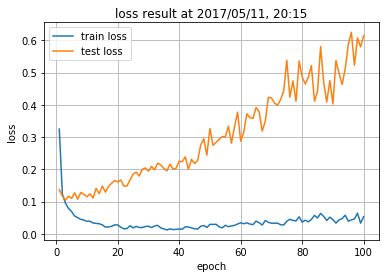

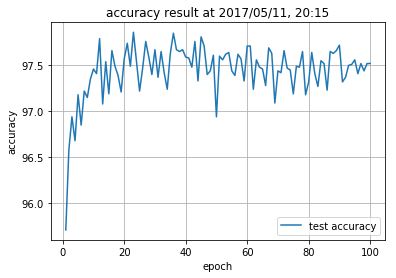

In [13]:
model = SimpleLinear()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
optim_results = run(100, train, test)
plot_results(*optim_results)

### Dropoutを追加

Training started at 2017-05-11, 20:20
Training
epoch: 1 [0/60000 (0%)]	loss:2.305609
Training
epoch: 1 [5000/60000 (8%)]	loss:1.208956
Training
epoch: 1 [10000/60000 (17%)]	loss:0.730129
Training
epoch: 1 [15000/60000 (25%)]	loss:0.624472
Training
epoch: 1 [20000/60000 (33%)]	loss:0.324685
Training
epoch: 1 [25000/60000 (42%)]	loss:0.198494
Training
epoch: 1 [30000/60000 (50%)]	loss:0.194596
Training
epoch: 1 [35000/60000 (58%)]	loss:0.468217
Training
epoch: 1 [40000/60000 (67%)]	loss:0.229806
Training
epoch: 1 [45000/60000 (75%)]	loss:0.189311
Training
epoch: 1 [50000/60000 (83%)]	loss:0.218399
Training
epoch: 1 [55000/60000 (92%)]	loss:0.124178
Test
Average loss: 0.1680,	Accuracy: 9502/10000 (95%)
one epoch takes 8.856561 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.249107
Training
epoch: 2 [5000/60000 (8%)]	loss:0.209196
Training
epoch: 2 [10000/60000 (17%)]	loss:0.113726
Training
epoch: 2 [15000/60000 (25%)]	loss:0.165542
Training
epoch: 2 [20000/60000 (33%)]	loss:0.164066
Training


Training
epoch: 13 [5000/60000 (8%)]	loss:0.263491
Training
epoch: 13 [10000/60000 (17%)]	loss:0.030366
Training
epoch: 13 [15000/60000 (25%)]	loss:0.007769
Training
epoch: 13 [20000/60000 (33%)]	loss:0.133499
Training
epoch: 13 [25000/60000 (42%)]	loss:0.017330
Training
epoch: 13 [30000/60000 (50%)]	loss:0.036320
Training
epoch: 13 [35000/60000 (58%)]	loss:0.080970
Training
epoch: 13 [40000/60000 (67%)]	loss:0.025309
Training
epoch: 13 [45000/60000 (75%)]	loss:0.097971
Training
epoch: 13 [50000/60000 (83%)]	loss:0.059005
Training
epoch: 13 [55000/60000 (92%)]	loss:0.058055
Test
Average loss: 0.0643,	Accuracy: 9816/10000 (98%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.014222
Training
epoch: 14 [5000/60000 (8%)]	loss:0.092235
Training
epoch: 14 [10000/60000 (17%)]	loss:0.010087
Training
epoch: 14 [15000/60000 (25%)]	loss:0.067271
Training
epoch: 14 [20000/60000 (33%)]	loss:0.027353
Training
epoch: 14 [25000/60000 (42%)]	loss:0.122502
Training
epoch: 14 [30000/60000 (50%)]	loss:0.006318
T

Training
epoch: 25 [5000/60000 (8%)]	loss:0.005945
Training
epoch: 25 [10000/60000 (17%)]	loss:0.002384
Training
epoch: 25 [15000/60000 (25%)]	loss:0.017742
Training
epoch: 25 [20000/60000 (33%)]	loss:0.059912
Training
epoch: 25 [25000/60000 (42%)]	loss:0.036911
Training
epoch: 25 [30000/60000 (50%)]	loss:0.002818
Training
epoch: 25 [35000/60000 (58%)]	loss:0.049478
Training
epoch: 25 [40000/60000 (67%)]	loss:0.030115
Training
epoch: 25 [45000/60000 (75%)]	loss:0.002276
Training
epoch: 25 [50000/60000 (83%)]	loss:0.012024
Training
epoch: 25 [55000/60000 (92%)]	loss:0.005436
Test
Average loss: 0.0759,	Accuracy: 9825/10000 (98%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.007974
Training
epoch: 26 [5000/60000 (8%)]	loss:0.056302
Training
epoch: 26 [10000/60000 (17%)]	loss:0.001982
Training
epoch: 26 [15000/60000 (25%)]	loss:0.034750
Training
epoch: 26 [20000/60000 (33%)]	loss:0.034219
Training
epoch: 26 [25000/60000 (42%)]	loss:0.002597
Training
epoch: 26 [30000/60000 (50%)]	loss:0.136211
T

Training
epoch: 37 [5000/60000 (8%)]	loss:0.099203
Training
epoch: 37 [10000/60000 (17%)]	loss:0.037065
Training
epoch: 37 [15000/60000 (25%)]	loss:0.050617
Training
epoch: 37 [20000/60000 (33%)]	loss:0.002186
Training
epoch: 37 [25000/60000 (42%)]	loss:0.001192
Training
epoch: 37 [30000/60000 (50%)]	loss:0.010375
Training
epoch: 37 [35000/60000 (58%)]	loss:0.003520
Training
epoch: 37 [40000/60000 (67%)]	loss:0.041324
Training
epoch: 37 [45000/60000 (75%)]	loss:0.004471
Training
epoch: 37 [50000/60000 (83%)]	loss:0.072625
Training
epoch: 37 [55000/60000 (92%)]	loss:0.033004
Test
Average loss: 0.0818,	Accuracy: 9831/10000 (98%)
Training
epoch: 38 [0/60000 (0%)]	loss:0.017080
Training
epoch: 38 [5000/60000 (8%)]	loss:0.018212
Training
epoch: 38 [10000/60000 (17%)]	loss:0.088635
Training
epoch: 38 [15000/60000 (25%)]	loss:0.082044
Training
epoch: 38 [20000/60000 (33%)]	loss:0.001684
Training
epoch: 38 [25000/60000 (42%)]	loss:0.001641
Training
epoch: 38 [30000/60000 (50%)]	loss:0.019383
T

Training
epoch: 49 [5000/60000 (8%)]	loss:0.014020
Training
epoch: 49 [10000/60000 (17%)]	loss:0.034737
Training
epoch: 49 [15000/60000 (25%)]	loss:0.002699
Training
epoch: 49 [20000/60000 (33%)]	loss:0.069950
Training
epoch: 49 [25000/60000 (42%)]	loss:0.061781
Training
epoch: 49 [30000/60000 (50%)]	loss:0.002052
Training
epoch: 49 [35000/60000 (58%)]	loss:0.200592
Training
epoch: 49 [40000/60000 (67%)]	loss:0.059929
Training
epoch: 49 [45000/60000 (75%)]	loss:0.011228
Training
epoch: 49 [50000/60000 (83%)]	loss:0.017610
Training
epoch: 49 [55000/60000 (92%)]	loss:0.002714
Test
Average loss: 0.0892,	Accuracy: 9834/10000 (98%)
Training
epoch: 50 [0/60000 (0%)]	loss:0.031015
Training
epoch: 50 [5000/60000 (8%)]	loss:0.015991
Training
epoch: 50 [10000/60000 (17%)]	loss:0.048279
Training
epoch: 50 [15000/60000 (25%)]	loss:0.162362
Training
epoch: 50 [20000/60000 (33%)]	loss:0.002100
Training
epoch: 50 [25000/60000 (42%)]	loss:0.007190
Training
epoch: 50 [30000/60000 (50%)]	loss:0.041137
T

Training
epoch: 61 [5000/60000 (8%)]	loss:0.100619
Training
epoch: 61 [10000/60000 (17%)]	loss:0.000240
Training
epoch: 61 [15000/60000 (25%)]	loss:0.001732
Training
epoch: 61 [20000/60000 (33%)]	loss:0.089893
Training
epoch: 61 [25000/60000 (42%)]	loss:0.039035
Training
epoch: 61 [30000/60000 (50%)]	loss:0.021575
Training
epoch: 61 [35000/60000 (58%)]	loss:0.000354
Training
epoch: 61 [40000/60000 (67%)]	loss:0.018252
Training
epoch: 61 [45000/60000 (75%)]	loss:0.045661
Training
epoch: 61 [50000/60000 (83%)]	loss:0.002040
Training
epoch: 61 [55000/60000 (92%)]	loss:0.011136
Test
Average loss: 0.0892,	Accuracy: 9825/10000 (98%)
Training
epoch: 62 [0/60000 (0%)]	loss:0.142901
Training
epoch: 62 [5000/60000 (8%)]	loss:0.103756
Training
epoch: 62 [10000/60000 (17%)]	loss:0.001668
Training
epoch: 62 [15000/60000 (25%)]	loss:0.017588
Training
epoch: 62 [20000/60000 (33%)]	loss:0.019390
Training
epoch: 62 [25000/60000 (42%)]	loss:0.028026
Training
epoch: 62 [30000/60000 (50%)]	loss:0.016043
T

Training
epoch: 73 [5000/60000 (8%)]	loss:0.111057
Training
epoch: 73 [10000/60000 (17%)]	loss:0.012959
Training
epoch: 73 [15000/60000 (25%)]	loss:0.000956
Training
epoch: 73 [20000/60000 (33%)]	loss:0.040904
Training
epoch: 73 [25000/60000 (42%)]	loss:0.010969
Training
epoch: 73 [30000/60000 (50%)]	loss:0.002647
Training
epoch: 73 [35000/60000 (58%)]	loss:0.011524
Training
epoch: 73 [40000/60000 (67%)]	loss:0.008283
Training
epoch: 73 [45000/60000 (75%)]	loss:0.003274
Training
epoch: 73 [50000/60000 (83%)]	loss:0.018653
Training
epoch: 73 [55000/60000 (92%)]	loss:0.013820
Test
Average loss: 0.0957,	Accuracy: 9836/10000 (98%)
Training
epoch: 74 [0/60000 (0%)]	loss:0.045855
Training
epoch: 74 [5000/60000 (8%)]	loss:0.007488
Training
epoch: 74 [10000/60000 (17%)]	loss:0.003959
Training
epoch: 74 [15000/60000 (25%)]	loss:0.003854
Training
epoch: 74 [20000/60000 (33%)]	loss:0.001084
Training
epoch: 74 [25000/60000 (42%)]	loss:0.063750
Training
epoch: 74 [30000/60000 (50%)]	loss:0.001014
T

Training
epoch: 85 [5000/60000 (8%)]	loss:0.053766
Training
epoch: 85 [10000/60000 (17%)]	loss:0.000139
Training
epoch: 85 [15000/60000 (25%)]	loss:0.028902
Training
epoch: 85 [20000/60000 (33%)]	loss:0.001279
Training
epoch: 85 [25000/60000 (42%)]	loss:0.003103
Training
epoch: 85 [30000/60000 (50%)]	loss:0.122678
Training
epoch: 85 [35000/60000 (58%)]	loss:0.007580
Training
epoch: 85 [40000/60000 (67%)]	loss:0.021166
Training
epoch: 85 [45000/60000 (75%)]	loss:0.218159
Training
epoch: 85 [50000/60000 (83%)]	loss:0.094696
Training
epoch: 85 [55000/60000 (92%)]	loss:0.049330
Test
Average loss: 0.0974,	Accuracy: 9837/10000 (98%)
Training
epoch: 86 [0/60000 (0%)]	loss:0.040057
Training
epoch: 86 [5000/60000 (8%)]	loss:0.005994
Training
epoch: 86 [10000/60000 (17%)]	loss:0.003123
Training
epoch: 86 [15000/60000 (25%)]	loss:0.038574
Training
epoch: 86 [20000/60000 (33%)]	loss:0.001750
Training
epoch: 86 [25000/60000 (42%)]	loss:0.002788
Training
epoch: 86 [30000/60000 (50%)]	loss:0.004632
T

Training
epoch: 97 [5000/60000 (8%)]	loss:0.042786
Training
epoch: 97 [10000/60000 (17%)]	loss:0.058338
Training
epoch: 97 [15000/60000 (25%)]	loss:0.000902
Training
epoch: 97 [20000/60000 (33%)]	loss:0.000675
Training
epoch: 97 [25000/60000 (42%)]	loss:0.000044
Training
epoch: 97 [30000/60000 (50%)]	loss:0.003401
Training
epoch: 97 [35000/60000 (58%)]	loss:0.004760
Training
epoch: 97 [40000/60000 (67%)]	loss:0.009209
Training
epoch: 97 [45000/60000 (75%)]	loss:0.000056
Training
epoch: 97 [50000/60000 (83%)]	loss:0.024003
Training
epoch: 97 [55000/60000 (92%)]	loss:0.000041
Test
Average loss: 0.1034,	Accuracy: 9824/10000 (98%)
Training
epoch: 98 [0/60000 (0%)]	loss:0.025741
Training
epoch: 98 [5000/60000 (8%)]	loss:0.000611
Training
epoch: 98 [10000/60000 (17%)]	loss:0.005968
Training
epoch: 98 [15000/60000 (25%)]	loss:0.005874
Training
epoch: 98 [20000/60000 (33%)]	loss:0.017467
Training
epoch: 98 [25000/60000 (42%)]	loss:0.005172
Training
epoch: 98 [30000/60000 (50%)]	loss:0.000262
T

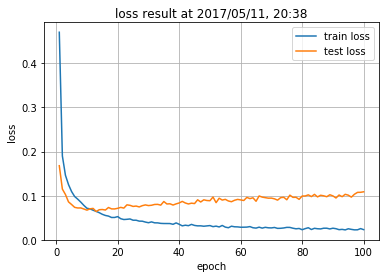

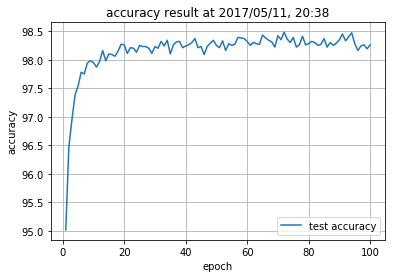

In [15]:
model = SimpleLinearDr()
optimizer = optim.Adam(model.parameters())
dr_results = run(100, train, test)
plot_results(*dr_results)

In [14]:
class ComplexLinear(nn.Module):
    
    def __init__(self, in_size=784, hidden_1=256, hidden_2=128, hidden_3=64, out_size=10, dr=True):
        super(ComplexLinear, self).__init__()
        self.dr_flag = dr
        self.fc1 = nn.Linear(in_size, hidden_1)
        if dr:
            self.dr1 = nn.Dropout()
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        if dr:
            self.dr2 = nn.Dropout()
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        if dr:
            self.dr3 = nn.Dropout()
        self.fc4 = nn.Linear(hidden_3, out_size)
    
    def forward(self, x):
        if self.dr_flag:
            h1 = F.relu(self.dr1(self.fc1(x.view(-1, 784))))
            h2 = F.relu(self.dr2(self.fc2(h1)))
            h3 = F.relu(self.dr3(self.fc3(h2)))
        else:
            h1 = F.relu(self.fc1(x.view(-1, 784)))
            h2 = F.relu(self.fc2(h1))
            h3 = F.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        return F.log_softmax(h4)

Training started at 2017-05-12, 12:36
Training
epoch: 1 [0/60000 (0%)]	loss:2.307820
Training
epoch: 1 [5000/60000 (8%)]	loss:0.808573
Training
epoch: 1 [10000/60000 (17%)]	loss:0.784000
Training
epoch: 1 [15000/60000 (25%)]	loss:0.520706
Training
epoch: 1 [20000/60000 (33%)]	loss:0.651265
Training
epoch: 1 [25000/60000 (42%)]	loss:0.457319
Training
epoch: 1 [30000/60000 (50%)]	loss:0.409364
Training
epoch: 1 [35000/60000 (58%)]	loss:0.403434
Training
epoch: 1 [40000/60000 (67%)]	loss:0.486875
Training
epoch: 1 [45000/60000 (75%)]	loss:0.377220
Training
epoch: 1 [50000/60000 (83%)]	loss:0.222903
Training
epoch: 1 [55000/60000 (92%)]	loss:0.271582
Test
Average loss: 0.1820,	Accuracy: 9470/10000 (95%)
one epoch takes 10.362607 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.274585
Training
epoch: 2 [5000/60000 (8%)]	loss:0.433769
Training
epoch: 2 [10000/60000 (17%)]	loss:0.112973
Training
epoch: 2 [15000/60000 (25%)]	loss:0.273361
Training
epoch: 2 [20000/60000 (33%)]	loss:0.403464
Training

Training
epoch: 13 [5000/60000 (8%)]	loss:0.052142
Training
epoch: 13 [10000/60000 (17%)]	loss:0.115094
Training
epoch: 13 [15000/60000 (25%)]	loss:0.053217
Training
epoch: 13 [20000/60000 (33%)]	loss:0.181404
Training
epoch: 13 [25000/60000 (42%)]	loss:0.125337
Training
epoch: 13 [30000/60000 (50%)]	loss:0.084616
Training
epoch: 13 [35000/60000 (58%)]	loss:0.053095
Training
epoch: 13 [40000/60000 (67%)]	loss:0.138920
Training
epoch: 13 [45000/60000 (75%)]	loss:0.017241
Training
epoch: 13 [50000/60000 (83%)]	loss:0.121864
Training
epoch: 13 [55000/60000 (92%)]	loss:0.161399
Test
Average loss: 0.0866,	Accuracy: 9768/10000 (98%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.068553
Training
epoch: 14 [5000/60000 (8%)]	loss:0.071626
Training
epoch: 14 [10000/60000 (17%)]	loss:0.046924
Training
epoch: 14 [15000/60000 (25%)]	loss:0.065054
Training
epoch: 14 [20000/60000 (33%)]	loss:0.069248
Training
epoch: 14 [25000/60000 (42%)]	loss:0.129734
Training
epoch: 14 [30000/60000 (50%)]	loss:0.083294
T

Training
epoch: 25 [5000/60000 (8%)]	loss:0.175906
Training
epoch: 25 [10000/60000 (17%)]	loss:0.206931
Training
epoch: 25 [15000/60000 (25%)]	loss:0.009940
Training
epoch: 25 [20000/60000 (33%)]	loss:0.091003
Training
epoch: 25 [25000/60000 (42%)]	loss:0.021636
Training
epoch: 25 [30000/60000 (50%)]	loss:0.066849
Training
epoch: 25 [35000/60000 (58%)]	loss:0.050454
Training
epoch: 25 [40000/60000 (67%)]	loss:0.299765
Training
epoch: 25 [45000/60000 (75%)]	loss:0.032829
Training
epoch: 25 [50000/60000 (83%)]	loss:0.104284
Training
epoch: 25 [55000/60000 (92%)]	loss:0.045984
Test
Average loss: 0.0860,	Accuracy: 9801/10000 (98%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.093162
Training
epoch: 26 [5000/60000 (8%)]	loss:0.023704
Training
epoch: 26 [10000/60000 (17%)]	loss:0.183100
Training
epoch: 26 [15000/60000 (25%)]	loss:0.088789
Training
epoch: 26 [20000/60000 (33%)]	loss:0.226450
Training
epoch: 26 [25000/60000 (42%)]	loss:0.081771
Training
epoch: 26 [30000/60000 (50%)]	loss:0.207181
T

Training
epoch: 37 [5000/60000 (8%)]	loss:0.260165
Training
epoch: 37 [10000/60000 (17%)]	loss:0.040155
Training
epoch: 37 [15000/60000 (25%)]	loss:0.187153
Training
epoch: 37 [20000/60000 (33%)]	loss:0.161985
Training
epoch: 37 [25000/60000 (42%)]	loss:0.011028
Training
epoch: 37 [30000/60000 (50%)]	loss:0.152625
Training
epoch: 37 [35000/60000 (58%)]	loss:0.122069
Training
epoch: 37 [40000/60000 (67%)]	loss:0.090153
Training
epoch: 37 [45000/60000 (75%)]	loss:0.005045
Training
epoch: 37 [50000/60000 (83%)]	loss:0.083652
Training
epoch: 37 [55000/60000 (92%)]	loss:0.329471
Test
Average loss: 0.0902,	Accuracy: 9791/10000 (98%)
Training
epoch: 38 [0/60000 (0%)]	loss:0.038013
Training
epoch: 38 [5000/60000 (8%)]	loss:0.065476
Training
epoch: 38 [10000/60000 (17%)]	loss:0.066652
Training
epoch: 38 [15000/60000 (25%)]	loss:0.165337
Training
epoch: 38 [20000/60000 (33%)]	loss:0.008077
Training
epoch: 38 [25000/60000 (42%)]	loss:0.067561
Training
epoch: 38 [30000/60000 (50%)]	loss:0.073578
T

Training
epoch: 49 [5000/60000 (8%)]	loss:0.220936
Training
epoch: 49 [10000/60000 (17%)]	loss:0.270022
Training
epoch: 49 [15000/60000 (25%)]	loss:0.082485
Training
epoch: 49 [20000/60000 (33%)]	loss:0.111256
Training
epoch: 49 [25000/60000 (42%)]	loss:0.008159
Training
epoch: 49 [30000/60000 (50%)]	loss:0.017330
Training
epoch: 49 [35000/60000 (58%)]	loss:0.027776
Training
epoch: 49 [40000/60000 (67%)]	loss:0.019440
Training
epoch: 49 [45000/60000 (75%)]	loss:0.012563
Training
epoch: 49 [50000/60000 (83%)]	loss:0.048741
Training
epoch: 49 [55000/60000 (92%)]	loss:0.031929
Test
Average loss: 0.0969,	Accuracy: 9810/10000 (98%)
Training
epoch: 50 [0/60000 (0%)]	loss:0.063962
Training
epoch: 50 [5000/60000 (8%)]	loss:0.014142
Training
epoch: 50 [10000/60000 (17%)]	loss:0.025800
Training
epoch: 50 [15000/60000 (25%)]	loss:0.024148
Training
epoch: 50 [20000/60000 (33%)]	loss:0.189476
Training
epoch: 50 [25000/60000 (42%)]	loss:0.068675
Training
epoch: 50 [30000/60000 (50%)]	loss:0.108481
T

Training
epoch: 61 [5000/60000 (8%)]	loss:0.218991
Training
epoch: 61 [10000/60000 (17%)]	loss:0.006684
Training
epoch: 61 [15000/60000 (25%)]	loss:0.024597
Training
epoch: 61 [20000/60000 (33%)]	loss:0.016072
Training
epoch: 61 [25000/60000 (42%)]	loss:0.042909
Training
epoch: 61 [30000/60000 (50%)]	loss:0.040805
Training
epoch: 61 [35000/60000 (58%)]	loss:0.034900
Training
epoch: 61 [40000/60000 (67%)]	loss:0.529460
Training
epoch: 61 [45000/60000 (75%)]	loss:0.041481
Training
epoch: 61 [50000/60000 (83%)]	loss:0.048921
Training
epoch: 61 [55000/60000 (92%)]	loss:0.085007
Test
Average loss: 0.1095,	Accuracy: 9796/10000 (98%)
Training
epoch: 62 [0/60000 (0%)]	loss:0.009610
Training
epoch: 62 [5000/60000 (8%)]	loss:0.007588
Training
epoch: 62 [10000/60000 (17%)]	loss:0.038637
Training
epoch: 62 [15000/60000 (25%)]	loss:0.018528
Training
epoch: 62 [20000/60000 (33%)]	loss:0.078800
Training
epoch: 62 [25000/60000 (42%)]	loss:0.125972
Training
epoch: 62 [30000/60000 (50%)]	loss:0.116180
T

Training
epoch: 73 [5000/60000 (8%)]	loss:0.030935
Training
epoch: 73 [10000/60000 (17%)]	loss:0.118214
Training
epoch: 73 [15000/60000 (25%)]	loss:0.021138
Training
epoch: 73 [20000/60000 (33%)]	loss:0.087281
Training
epoch: 73 [25000/60000 (42%)]	loss:0.439856
Training
epoch: 73 [30000/60000 (50%)]	loss:0.038239
Training
epoch: 73 [35000/60000 (58%)]	loss:0.066032
Training
epoch: 73 [40000/60000 (67%)]	loss:0.068966
Training
epoch: 73 [45000/60000 (75%)]	loss:0.009875
Training
epoch: 73 [50000/60000 (83%)]	loss:0.019482
Training
epoch: 73 [55000/60000 (92%)]	loss:0.134715
Test
Average loss: 0.1148,	Accuracy: 9797/10000 (98%)
Training
epoch: 74 [0/60000 (0%)]	loss:0.106451
Training
epoch: 74 [5000/60000 (8%)]	loss:0.010823
Training
epoch: 74 [10000/60000 (17%)]	loss:0.003485
Training
epoch: 74 [15000/60000 (25%)]	loss:0.023981
Training
epoch: 74 [20000/60000 (33%)]	loss:0.007705
Training
epoch: 74 [25000/60000 (42%)]	loss:0.049197
Training
epoch: 74 [30000/60000 (50%)]	loss:0.012212
T

Training
epoch: 85 [5000/60000 (8%)]	loss:0.027028
Training
epoch: 85 [10000/60000 (17%)]	loss:0.044201
Training
epoch: 85 [15000/60000 (25%)]	loss:0.020649
Training
epoch: 85 [20000/60000 (33%)]	loss:0.070072
Training
epoch: 85 [25000/60000 (42%)]	loss:0.010036
Training
epoch: 85 [30000/60000 (50%)]	loss:0.021807
Training
epoch: 85 [35000/60000 (58%)]	loss:0.167033
Training
epoch: 85 [40000/60000 (67%)]	loss:0.028142
Training
epoch: 85 [45000/60000 (75%)]	loss:0.095505
Training
epoch: 85 [50000/60000 (83%)]	loss:0.106334
Training
epoch: 85 [55000/60000 (92%)]	loss:0.190388
Test
Average loss: 0.1225,	Accuracy: 9793/10000 (98%)
Training
epoch: 86 [0/60000 (0%)]	loss:0.026017
Training
epoch: 86 [5000/60000 (8%)]	loss:0.038754
Training
epoch: 86 [10000/60000 (17%)]	loss:0.042639
Training
epoch: 86 [15000/60000 (25%)]	loss:0.024869
Training
epoch: 86 [20000/60000 (33%)]	loss:0.079153
Training
epoch: 86 [25000/60000 (42%)]	loss:0.007659
Training
epoch: 86 [30000/60000 (50%)]	loss:0.002974
T

Training
epoch: 97 [5000/60000 (8%)]	loss:0.063938
Training
epoch: 97 [10000/60000 (17%)]	loss:0.006024
Training
epoch: 97 [15000/60000 (25%)]	loss:0.001353
Training
epoch: 97 [20000/60000 (33%)]	loss:0.004519
Training
epoch: 97 [25000/60000 (42%)]	loss:0.009985
Training
epoch: 97 [30000/60000 (50%)]	loss:0.039141
Training
epoch: 97 [35000/60000 (58%)]	loss:0.007583
Training
epoch: 97 [40000/60000 (67%)]	loss:0.027777
Training
epoch: 97 [45000/60000 (75%)]	loss:0.024462
Training
epoch: 97 [50000/60000 (83%)]	loss:0.045146
Training
epoch: 97 [55000/60000 (92%)]	loss:0.007640
Test
Average loss: 0.1191,	Accuracy: 9806/10000 (98%)
Training
epoch: 98 [0/60000 (0%)]	loss:0.097744
Training
epoch: 98 [5000/60000 (8%)]	loss:0.128080
Training
epoch: 98 [10000/60000 (17%)]	loss:0.130426
Training
epoch: 98 [15000/60000 (25%)]	loss:0.190487
Training
epoch: 98 [20000/60000 (33%)]	loss:0.076281
Training
epoch: 98 [25000/60000 (42%)]	loss:0.004686
Training
epoch: 98 [30000/60000 (50%)]	loss:0.001452
T

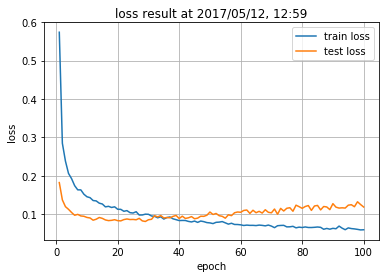

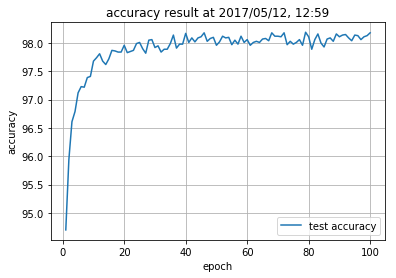

In [11]:
# complex model
model = ComplexLinear()
optimizer = optim.Adam(model.parameters())
complex_w_dr_results = run(100, train, test)
plot_results(*complex_w_dr_results)

Training started at 2017-05-12, 13:05
Training
epoch: 1 [0/60000 (0%)]	loss:2.309309
Training
epoch: 1 [5000/60000 (8%)]	loss:0.503927
Training
epoch: 1 [10000/60000 (17%)]	loss:0.227289
Training
epoch: 1 [15000/60000 (25%)]	loss:0.339658
Training
epoch: 1 [20000/60000 (33%)]	loss:0.355115
Training
epoch: 1 [25000/60000 (42%)]	loss:0.278722
Training
epoch: 1 [30000/60000 (50%)]	loss:0.183389
Training
epoch: 1 [35000/60000 (58%)]	loss:0.063071
Training
epoch: 1 [40000/60000 (67%)]	loss:0.296923
Training
epoch: 1 [45000/60000 (75%)]	loss:0.200759
Training
epoch: 1 [50000/60000 (83%)]	loss:0.336088
Training
epoch: 1 [55000/60000 (92%)]	loss:0.194915
Test
Average loss: 0.1255,	Accuracy: 9633/10000 (96%)
one epoch takes 8.729069 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.031945
Training
epoch: 2 [5000/60000 (8%)]	loss:0.124583
Training
epoch: 2 [10000/60000 (17%)]	loss:0.079605
Training
epoch: 2 [15000/60000 (25%)]	loss:0.210533
Training
epoch: 2 [20000/60000 (33%)]	loss:0.150662
Training


Training
epoch: 13 [5000/60000 (8%)]	loss:0.001639
Training
epoch: 13 [10000/60000 (17%)]	loss:0.000138
Training
epoch: 13 [15000/60000 (25%)]	loss:0.002338
Training
epoch: 13 [20000/60000 (33%)]	loss:0.039407
Training
epoch: 13 [25000/60000 (42%)]	loss:0.000663
Training
epoch: 13 [30000/60000 (50%)]	loss:0.107098
Training
epoch: 13 [35000/60000 (58%)]	loss:0.002566
Training
epoch: 13 [40000/60000 (67%)]	loss:0.017192
Training
epoch: 13 [45000/60000 (75%)]	loss:0.002845
Training
epoch: 13 [50000/60000 (83%)]	loss:0.001111
Training
epoch: 13 [55000/60000 (92%)]	loss:0.012031
Test
Average loss: 0.0903,	Accuracy: 9800/10000 (98%)
Training
epoch: 14 [0/60000 (0%)]	loss:0.000103
Training
epoch: 14 [5000/60000 (8%)]	loss:0.000348
Training
epoch: 14 [10000/60000 (17%)]	loss:0.029379
Training
epoch: 14 [15000/60000 (25%)]	loss:0.003047
Training
epoch: 14 [20000/60000 (33%)]	loss:0.017341
Training
epoch: 14 [25000/60000 (42%)]	loss:0.000351
Training
epoch: 14 [30000/60000 (50%)]	loss:0.000136
T

Training
epoch: 25 [5000/60000 (8%)]	loss:0.005212
Training
epoch: 25 [10000/60000 (17%)]	loss:0.000846
Training
epoch: 25 [15000/60000 (25%)]	loss:0.000009
Training
epoch: 25 [20000/60000 (33%)]	loss:0.000374
Training
epoch: 25 [25000/60000 (42%)]	loss:0.001052
Training
epoch: 25 [30000/60000 (50%)]	loss:0.000016
Training
epoch: 25 [35000/60000 (58%)]	loss:0.010921
Training
epoch: 25 [40000/60000 (67%)]	loss:0.000018
Training
epoch: 25 [45000/60000 (75%)]	loss:0.000406
Training
epoch: 25 [50000/60000 (83%)]	loss:0.053905
Training
epoch: 25 [55000/60000 (92%)]	loss:0.000173
Test
Average loss: 0.0977,	Accuracy: 9835/10000 (98%)
Training
epoch: 26 [0/60000 (0%)]	loss:0.000077
Training
epoch: 26 [5000/60000 (8%)]	loss:0.021950
Training
epoch: 26 [10000/60000 (17%)]	loss:0.000037
Training
epoch: 26 [15000/60000 (25%)]	loss:0.001560
Training
epoch: 26 [20000/60000 (33%)]	loss:0.000178
Training
epoch: 26 [25000/60000 (42%)]	loss:0.000180
Training
epoch: 26 [30000/60000 (50%)]	loss:0.000006
T

Training
epoch: 37 [5000/60000 (8%)]	loss:0.000007
Training
epoch: 37 [10000/60000 (17%)]	loss:0.000021
Training
epoch: 37 [15000/60000 (25%)]	loss:0.000350
Training
epoch: 37 [20000/60000 (33%)]	loss:0.024975
Training
epoch: 37 [25000/60000 (42%)]	loss:0.000001
Training
epoch: 37 [30000/60000 (50%)]	loss:0.000043
Training
epoch: 37 [35000/60000 (58%)]	loss:0.000057
Training
epoch: 37 [40000/60000 (67%)]	loss:0.003374
Training
epoch: 37 [45000/60000 (75%)]	loss:0.000110
Training
epoch: 37 [50000/60000 (83%)]	loss:0.157923
Training
epoch: 37 [55000/60000 (92%)]	loss:0.000598
Test
Average loss: 0.1142,	Accuracy: 9825/10000 (98%)
Training
epoch: 38 [0/60000 (0%)]	loss:0.000007
Training
epoch: 38 [5000/60000 (8%)]	loss:0.000001
Training
epoch: 38 [10000/60000 (17%)]	loss:0.068413
Training
epoch: 38 [15000/60000 (25%)]	loss:0.006603
Training
epoch: 38 [20000/60000 (33%)]	loss:0.060051
Training
epoch: 38 [25000/60000 (42%)]	loss:0.000007
Training
epoch: 38 [30000/60000 (50%)]	loss:0.000386
T

Training
epoch: 49 [5000/60000 (8%)]	loss:0.000536
Training
epoch: 49 [10000/60000 (17%)]	loss:0.033783
Training
epoch: 49 [15000/60000 (25%)]	loss:0.004877
Training
epoch: 49 [20000/60000 (33%)]	loss:0.006515
Training
epoch: 49 [25000/60000 (42%)]	loss:0.000080
Training
epoch: 49 [30000/60000 (50%)]	loss:0.012415
Training
epoch: 49 [35000/60000 (58%)]	loss:0.000374
Training
epoch: 49 [40000/60000 (67%)]	loss:0.002270
Training
epoch: 49 [45000/60000 (75%)]	loss:0.000198
Training
epoch: 49 [50000/60000 (83%)]	loss:0.000004
Training
epoch: 49 [55000/60000 (92%)]	loss:0.000994
Test
Average loss: 0.1295,	Accuracy: 9817/10000 (98%)
Training
epoch: 50 [0/60000 (0%)]	loss:0.000103
Training
epoch: 50 [5000/60000 (8%)]	loss:0.035435
Training
epoch: 50 [10000/60000 (17%)]	loss:0.000000
Training
epoch: 50 [15000/60000 (25%)]	loss:0.000118
Training
epoch: 50 [20000/60000 (33%)]	loss:0.000414
Training
epoch: 50 [25000/60000 (42%)]	loss:0.000326
Training
epoch: 50 [30000/60000 (50%)]	loss:0.000061
T

Training
epoch: 61 [5000/60000 (8%)]	loss:0.000389
Training
epoch: 61 [10000/60000 (17%)]	loss:0.000117
Training
epoch: 61 [15000/60000 (25%)]	loss:0.000025
Training
epoch: 61 [20000/60000 (33%)]	loss:0.000871
Training
epoch: 61 [25000/60000 (42%)]	loss:0.000028
Training
epoch: 61 [30000/60000 (50%)]	loss:0.000026
Training
epoch: 61 [35000/60000 (58%)]	loss:0.000163
Training
epoch: 61 [40000/60000 (67%)]	loss:0.002648
Training
epoch: 61 [45000/60000 (75%)]	loss:0.000000
Training
epoch: 61 [50000/60000 (83%)]	loss:0.000007
Training
epoch: 61 [55000/60000 (92%)]	loss:0.005244
Test
Average loss: 0.1550,	Accuracy: 9795/10000 (98%)
Training
epoch: 62 [0/60000 (0%)]	loss:0.000006
Training
epoch: 62 [5000/60000 (8%)]	loss:0.001195
Training
epoch: 62 [10000/60000 (17%)]	loss:0.000118
Training
epoch: 62 [15000/60000 (25%)]	loss:0.000004
Training
epoch: 62 [20000/60000 (33%)]	loss:0.000002
Training
epoch: 62 [25000/60000 (42%)]	loss:0.000066
Training
epoch: 62 [30000/60000 (50%)]	loss:0.000001
T

Training
epoch: 73 [5000/60000 (8%)]	loss:0.000000
Training
epoch: 73 [10000/60000 (17%)]	loss:0.000000
Training
epoch: 73 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 73 [20000/60000 (33%)]	loss:0.000001
Training
epoch: 73 [25000/60000 (42%)]	loss:0.000207
Training
epoch: 73 [30000/60000 (50%)]	loss:0.000000
Training
epoch: 73 [35000/60000 (58%)]	loss:0.196906
Training
epoch: 73 [40000/60000 (67%)]	loss:0.000000
Training
epoch: 73 [45000/60000 (75%)]	loss:0.000002
Training
epoch: 73 [50000/60000 (83%)]	loss:0.000001
Training
epoch: 73 [55000/60000 (92%)]	loss:0.000006
Test
Average loss: 0.1726,	Accuracy: 9813/10000 (98%)
Training
epoch: 74 [0/60000 (0%)]	loss:0.000955
Training
epoch: 74 [5000/60000 (8%)]	loss:0.000001
Training
epoch: 74 [10000/60000 (17%)]	loss:0.000210
Training
epoch: 74 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 74 [20000/60000 (33%)]	loss:0.000006
Training
epoch: 74 [25000/60000 (42%)]	loss:0.000300
Training
epoch: 74 [30000/60000 (50%)]	loss:0.000027
T

Training
epoch: 85 [5000/60000 (8%)]	loss:0.000060
Training
epoch: 85 [10000/60000 (17%)]	loss:0.000049
Training
epoch: 85 [15000/60000 (25%)]	loss:0.000000
Training
epoch: 85 [20000/60000 (33%)]	loss:0.063932
Training
epoch: 85 [25000/60000 (42%)]	loss:0.000463
Training
epoch: 85 [30000/60000 (50%)]	loss:0.000001
Training
epoch: 85 [35000/60000 (58%)]	loss:0.000000
Training
epoch: 85 [40000/60000 (67%)]	loss:0.000000
Training
epoch: 85 [45000/60000 (75%)]	loss:0.000001
Training
epoch: 85 [50000/60000 (83%)]	loss:0.000005
Training
epoch: 85 [55000/60000 (92%)]	loss:0.000001
Test
Average loss: 0.1791,	Accuracy: 9826/10000 (98%)
Training
epoch: 86 [0/60000 (0%)]	loss:0.000030
Training
epoch: 86 [5000/60000 (8%)]	loss:0.000018
Training
epoch: 86 [10000/60000 (17%)]	loss:0.000003
Training
epoch: 86 [15000/60000 (25%)]	loss:0.000052
Training
epoch: 86 [20000/60000 (33%)]	loss:0.000003
Training
epoch: 86 [25000/60000 (42%)]	loss:0.000000
Training
epoch: 86 [30000/60000 (50%)]	loss:0.001921
T

Training
epoch: 97 [5000/60000 (8%)]	loss:0.000001
Training
epoch: 97 [10000/60000 (17%)]	loss:0.000001
Training
epoch: 97 [15000/60000 (25%)]	loss:0.000001
Training
epoch: 97 [20000/60000 (33%)]	loss:0.000006
Training
epoch: 97 [25000/60000 (42%)]	loss:0.000001
Training
epoch: 97 [30000/60000 (50%)]	loss:0.000002
Training
epoch: 97 [35000/60000 (58%)]	loss:0.000048
Training
epoch: 97 [40000/60000 (67%)]	loss:0.000204
Training
epoch: 97 [45000/60000 (75%)]	loss:0.000202
Training
epoch: 97 [50000/60000 (83%)]	loss:0.000006
Training
epoch: 97 [55000/60000 (92%)]	loss:0.000007
Test
Average loss: 0.1759,	Accuracy: 9809/10000 (98%)
Training
epoch: 98 [0/60000 (0%)]	loss:0.000001
Training
epoch: 98 [5000/60000 (8%)]	loss:0.000000
Training
epoch: 98 [10000/60000 (17%)]	loss:0.000026
Training
epoch: 98 [15000/60000 (25%)]	loss:0.000007
Training
epoch: 98 [20000/60000 (33%)]	loss:0.000000
Training
epoch: 98 [25000/60000 (42%)]	loss:0.000001
Training
epoch: 98 [30000/60000 (50%)]	loss:0.000065
T

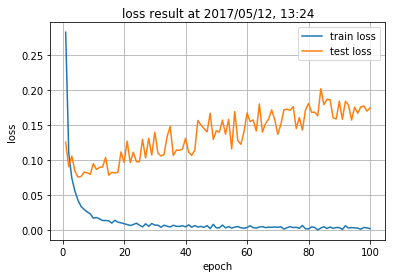

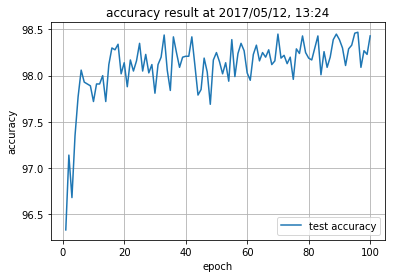

In [15]:
model = ComplexLinear(dr=False)
optimizer = optim.Adam(model.parameters())
results_nodr = run(100, train, test)
plot_results(*results_nodr)

# オートエンコーダー
前回、あんなにオートエンコーダーの話をしたのに、ここでしないわけにいきません。
オートエンコーダでは、データの大きさは砂時計のように入出力時が大きく、中間で一番小さくなるように設計します。ここでも、各層での次元数は任意です。今回はクラス数に合わせて、$10$次元に潰してみましょう

![autoencoder](./images/autoencoder.png)

In [157]:
class AutoEncoder(nn.Module):
    
    def __init__(self, in_size=784, hidden_size=256, latent_size=10):
        super(AutoEncoder, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, in_size)
    
    def forward(self, x):
        h = F.relu(self.fc1(x.view(-1, 784)))
        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        return self.fc4(h)
    
    def infer(self, x):
        h = F.relu(self.fc1(x.view(-1, 784)))
        return self.fc2(h)

In [159]:
class AutoEncoderDR(nn.Module):
    
    def __init__(self, in_size=784, hidden_size=256, latent_size=10):
        super(AutoEncoderDR, self).__init__()
        self.fc1 = nn.Linear(in_size, hidden_size)
        self.dr1 = nn.Dropout()
        self.fc2 = nn.Linear(hidden_size, latent_size)
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.dr3 = nn.Dropout()
        self.fc4 = nn.Linear(hidden_size, in_size)
    
    def forward(self, x):
        x = x.view(-1, 784)
        for i in range(1, 4):
            x = getattr(self, 'fc{}'.format(i))(x)
            if i != 2:
                x = getattr(self, 'dr{}'.format(i))(x)
            x = F.sigmoid(x)
        return self.fc4(x)

In [160]:
def train_ae(epoch, ae, log_interval=100):
    ae.train()
    train_loss = .0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        output = ae(data)
        reconstruction_loss = (output - data) * (output - data)
        reconstruction_loss = reconstruction_loss.mean()
        train_loss += reconstruction_loss.data[0]
        reconstruction_loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Training')
            print('epoch: {} [{}/{} ({:.0f}%)]\tloss:{:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),
                                                                   100. * batch_idx / len(train_loader), reconstruction_loss.data[0]))
    return train_loss / len(train_loader)

def test_ae(epoch, ae):
    ae.eval()
    test_loss = .0
    for (data, _) in test_loader:
        data = Variable(data, volatile=True)
        output = ae(data)
        reconstruction_loss = (output - data) * (output - data)
        test_loss += reconstruction_loss.mean().data[0]
    test_loss /= len(test_loader)
    print('Test')
    print('Average loss: {:.4f}'.format(test_loss))
    return test_loss

In [161]:
def run_ae(n_epoch, train_ae, test_ae):
    train_loss = []
    test_loss = []
    start_time = datetime.datetime.now()
    f_start = start_time.strftime('%H%M')
    print('Training AutoEncoder started at {}'.format(start_time.strftime('%Y/%m/%d, %H:%M')))
    for epoch in range(1, n_epoch + 1):
        if epoch == 1:
            start = datetime.datetime.now()
        train_loss.append(train_ae(epoch, ae))
        test_loss.append(test_ae(epoch, ae))
        if epoch == 1:
            end = datetime.datetime.now()
            print('# one loop takes {} sec'.format((end - start).total_seconds()))
    end_time = datetime.datetime.now()
    print('Training AutoEncoder finishied at {}'.format(end_time.strftime('%Y/%m/%d, %H:%M')))
    print('Duration: {} sec'.format((end_time - start_time).total_seconds()))
    return train_loss, test_loss

In [ ]:
ae = AutoEncoder()
optimizer = optim.Adam(ae.parameters())
results_ae = run_ae(50, train_ae, test_ae)

Training AutoEncoder started at 2017/05/11, 16:32
Training
epoch: 1 [0/60000 (0%)]	loss:0.113396
Training
epoch: 1 [5000/60000 (8%)]	loss:0.115838
Training
epoch: 1 [10000/60000 (17%)]	loss:0.077475
Training
epoch: 1 [15000/60000 (25%)]	loss:0.069705
Training
epoch: 1 [20000/60000 (33%)]	loss:0.069284
Training
epoch: 1 [25000/60000 (42%)]	loss:0.070377
Training
epoch: 1 [30000/60000 (50%)]	loss:0.077043
Training
epoch: 1 [35000/60000 (58%)]	loss:0.084685
Training
epoch: 1 [40000/60000 (67%)]	loss:0.074990
Training
epoch: 1 [45000/60000 (75%)]	loss:0.088589
Training
epoch: 1 [50000/60000 (83%)]	loss:0.100966
Training
epoch: 1 [55000/60000 (92%)]	loss:0.085451
Test
Average loss: 0.0924
# one loop takes 10.868415 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.095913
Training
epoch: 2 [5000/60000 (8%)]	loss:0.090321
Training
epoch: 2 [10000/60000 (17%)]	loss:0.082706
Training
epoch: 2 [15000/60000 (25%)]	loss:0.085859
Training
epoch: 2 [20000/60000 (33%)]	loss:0.081111
Training
epoch: 2 [2500

Training
epoch: 13 [35000/60000 (58%)]	loss:0.118053
Training
epoch: 13 [40000/60000 (67%)]	loss:0.125756
Training
epoch: 13 [45000/60000 (75%)]	loss:0.121590
Training
epoch: 13 [50000/60000 (83%)]	loss:0.122797
Training
epoch: 13 [55000/60000 (92%)]	loss:0.125080
Test
Average loss: 0.1266
Training
epoch: 14 [0/60000 (0%)]	loss:0.122180
Training
epoch: 14 [5000/60000 (8%)]	loss:0.125376
Training
epoch: 14 [10000/60000 (17%)]	loss:0.127776
Training
epoch: 14 [15000/60000 (25%)]	loss:0.121563
Training
epoch: 14 [20000/60000 (33%)]	loss:0.122265
Training
epoch: 14 [25000/60000 (42%)]	loss:0.118645
Training
epoch: 14 [30000/60000 (50%)]	loss:0.124485
Training
epoch: 14 [35000/60000 (58%)]	loss:0.128667
Training
epoch: 14 [40000/60000 (67%)]	loss:0.129672
Training
epoch: 14 [45000/60000 (75%)]	loss:0.134051
Training
epoch: 14 [50000/60000 (83%)]	loss:0.122652
Training
epoch: 14 [55000/60000 (92%)]	loss:0.120704
Test
Average loss: 0.1230
Training
epoch: 15 [0/60000 (0%)]	loss:0.124264
Traini

In [122]:
ae_bn = AutoEncoderBN()
optimizer = optim.Adam(ae.parameters())
results_ae = run_ae(100, train_ae, test_ae)

Training AutoEncoder started at 2017/05/11, 15:47
Training
epoch: 1 [0/60000 (0%)]	loss:0.165255
Test
Average loss: 0.0781
# one loop takes 14.430543 sec
Training
epoch: 2 [0/60000 (0%)]	loss:0.084252
Test
Average loss: 0.0864
Training
epoch: 3 [0/60000 (0%)]	loss:0.082465
Test
Average loss: 0.0940
Training
epoch: 4 [0/60000 (0%)]	loss:0.132576
Test
Average loss: 0.0988
Training
epoch: 5 [0/60000 (0%)]	loss:0.096193
Test
Average loss: 0.1043
Training
epoch: 6 [0/60000 (0%)]	loss:0.103545
Test
Average loss: 0.1086
Training
epoch: 7 [0/60000 (0%)]	loss:0.110652
Test
Average loss: 0.1112
Training
epoch: 8 [0/60000 (0%)]	loss:0.109589
Test
Average loss: 0.1131
Training
epoch: 9 [0/60000 (0%)]	loss:0.115171
Test
Average loss: 0.1181
Training
epoch: 10 [0/60000 (0%)]	loss:0.115269
Test
Average loss: 0.1173
Training
epoch: 11 [0/60000 (0%)]	loss:0.121873
Test
Average loss: 0.1186
Training
epoch: 12 [0/60000 (0%)]	loss:0.118167
Test
Average loss: 0.3166
Training
epoch: 13 [0/60000 (0%)]	loss:0

In [131]:
ae_dr = AutoEncoderDR()
optimizer = optim.Adam(ae.parameters())
results_ae = run_ae(10, train_ae, test_ae)

Training AutoEncoder started at 2017/05/11, 16:20
Training
epoch: 1 [0/60000 (0%)]	loss:0.204583
Test
Average loss: 0.8796
# one loop takes 11.263299 sec
Training
epoch: 2 [0/60000 (0%)]	loss:54.460697
Test
Average loss: 0.1632
Training
epoch: 3 [0/60000 (0%)]	loss:89.054329
Test
Average loss: 0.1409
Training
epoch: 4 [0/60000 (0%)]	loss:113.879425
Test
Average loss: 0.1577
Training
epoch: 5 [0/60000 (0%)]	loss:139.728851
Test
Average loss: 0.1497
Training
epoch: 6 [0/60000 (0%)]	loss:156.644028
Test
Average loss: 0.1441
Training
epoch: 7 [0/60000 (0%)]	loss:160.812637
Test
Average loss: 0.1444
Training
epoch: 8 [0/60000 (0%)]	loss:167.420593
Test
Average loss: 0.1498
Training
epoch: 9 [0/60000 (0%)]	loss:180.920288
Test
Average loss: 0.1614
Training
epoch: 10 [0/60000 (0%)]	loss:204.971878
Test
Average loss: 0.1750
Training AutoEncoder finishied at 2017/05/11, 16:22
Duration: 113.361255 sec


In [124]:
def calculate_latent(ae):
    ae.eval()
    x0_list = []
    x1_list = []
    label_list = [] 
    for (data, target) in test_loader:
        data = Variable(data, volatile=True)
        latent = ae.infer(data).data.numpy().transpose(1, 0)
        x0_list.extend(list(latent[0, :]))
        x1_list.extend(list(latent[0, :]))
        label_list.extend(list(target))
    return pd.DataFrame({'x0': x0_list, 'x1': x1_list, 'digit': label_list})

In [146]:
def reconstruct_mnist(ae):
    ae.eval()
    original_data = []
    reconstruncted = []
    digit_list = []
    for (data, target) in test_loader:
        data = Variable(data, volatile=True)
        reconstruncted_data = np.transpose(ae(data).view(-1, 1, 28, 28).data.numpy(), (0, 2, 3, 1))
        original_data.extend(list(data.data.numpy().transpose(0, 2, 3, 1)))
        reconstruncted.extend(list(reconstruncted_data))
        digit_list.extend(list(target))
    return original_data, reconstruncted, digit_list

<class 'tuple'>
<class 'list'>
<class 'numpy.ndarray'>
(28, 28, 1)


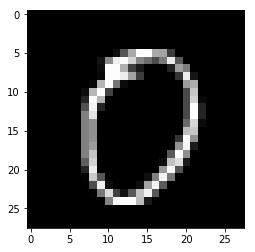

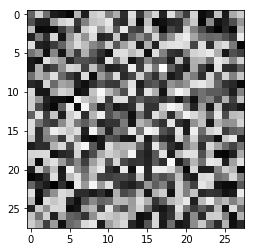

In [156]:
print(type(result_ae))
print(type(result_ae[0]))
print(type(result_ae[0][0]))
print(result_ae[0][0].shape)

plt.imshow(result_ae[0][0][:, :, 0], cmap='gray')
plt.show()

plt.imshow(result_ae[1][0][:, :, 0], cmap='gray')